In [1]:
import os

import numpyro
from jax import random
from luxglm.inference import run_nuts
from luxglm.utils import get_input_data
from visualization import (
    plot_coefficients,
    plot_experimental_parameters,
    plot_methylation_levels,
)

numpyro.enable_x64()
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

## One-step estimation


### Read input data


In [2]:
luxglm_input_data = get_input_data("metadata.tsv")

### Estimate posterior distributions


In [3]:
key = random.PRNGKey(0)

key, key_ = random.split(key)
lux_result = run_nuts(
    key,
    luxglm_input_data,
    ["basal/tgf-beta", "vitc", "ra"],
    num_warmup=1_000,
    num_samples=1_000,
    num_chains=4,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

### Ensure convergence


In [4]:
display(lux_result.inference_metrics["summary"].query("r_hat > 1.05"))

,variable,index,mean,std,median,5.0%,95.0%,n_eff,r_hat


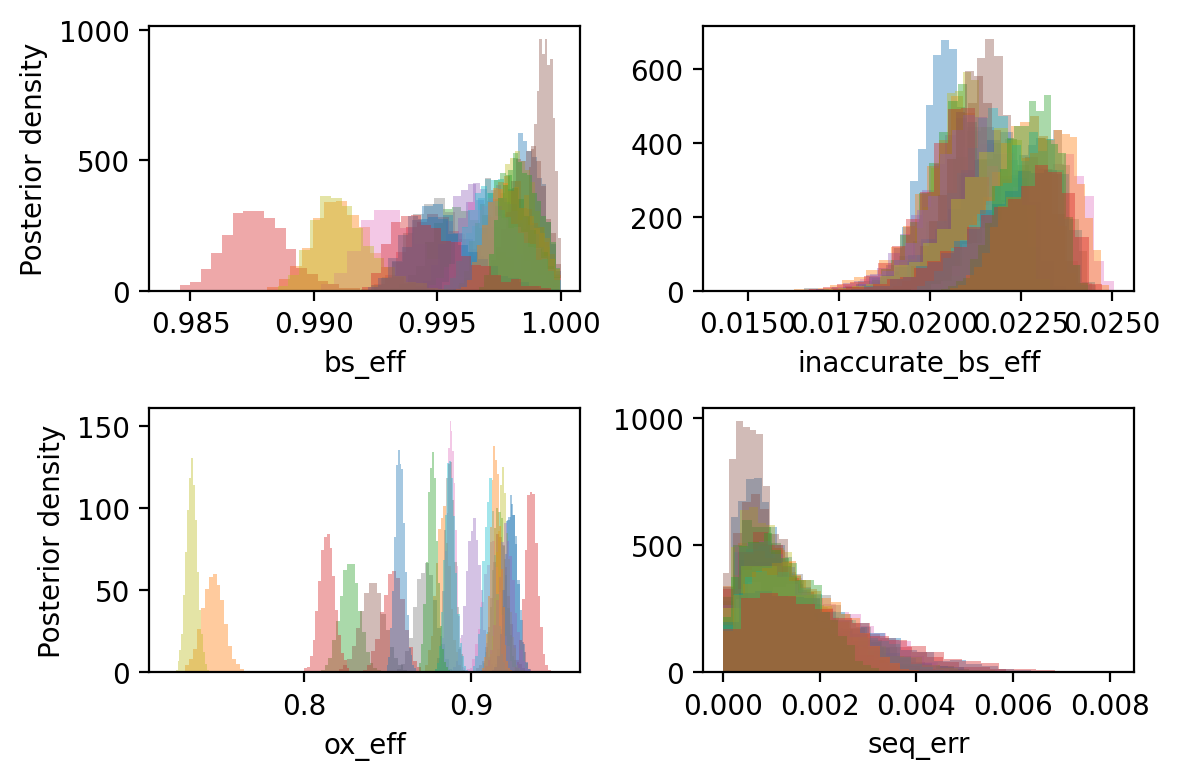

In [5]:
plot_experimental_parameters(lux_result);

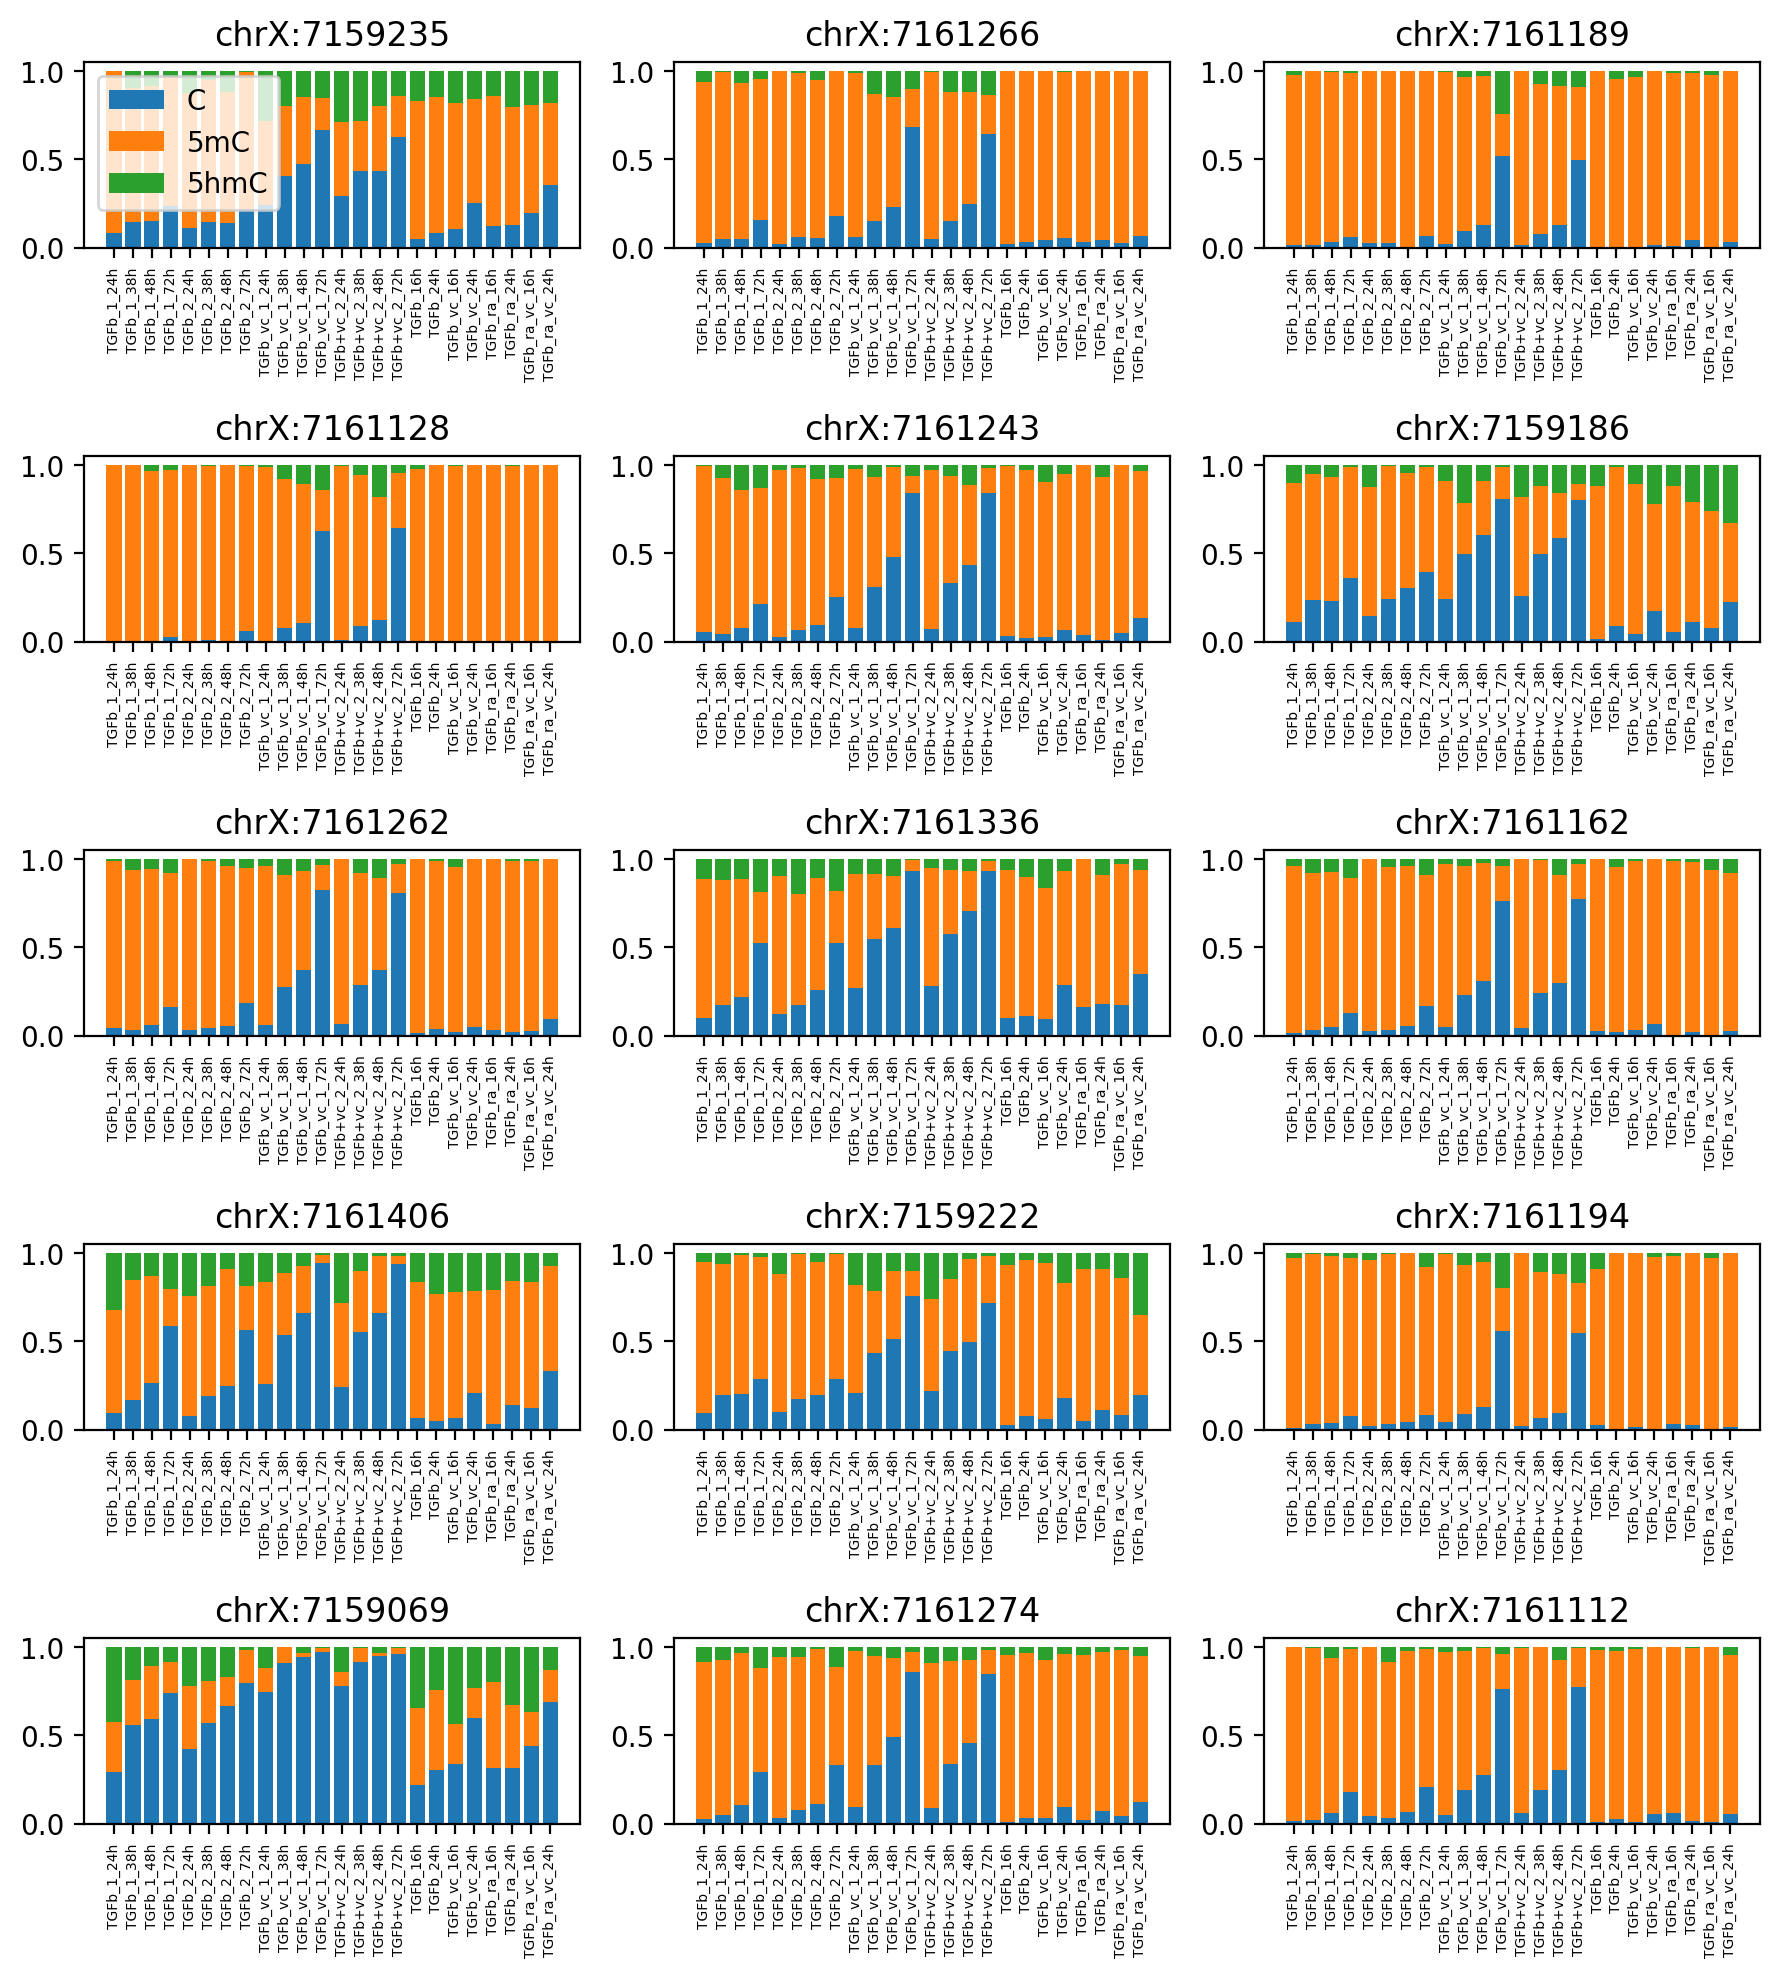

In [6]:
plot_methylation_levels(lux_result);

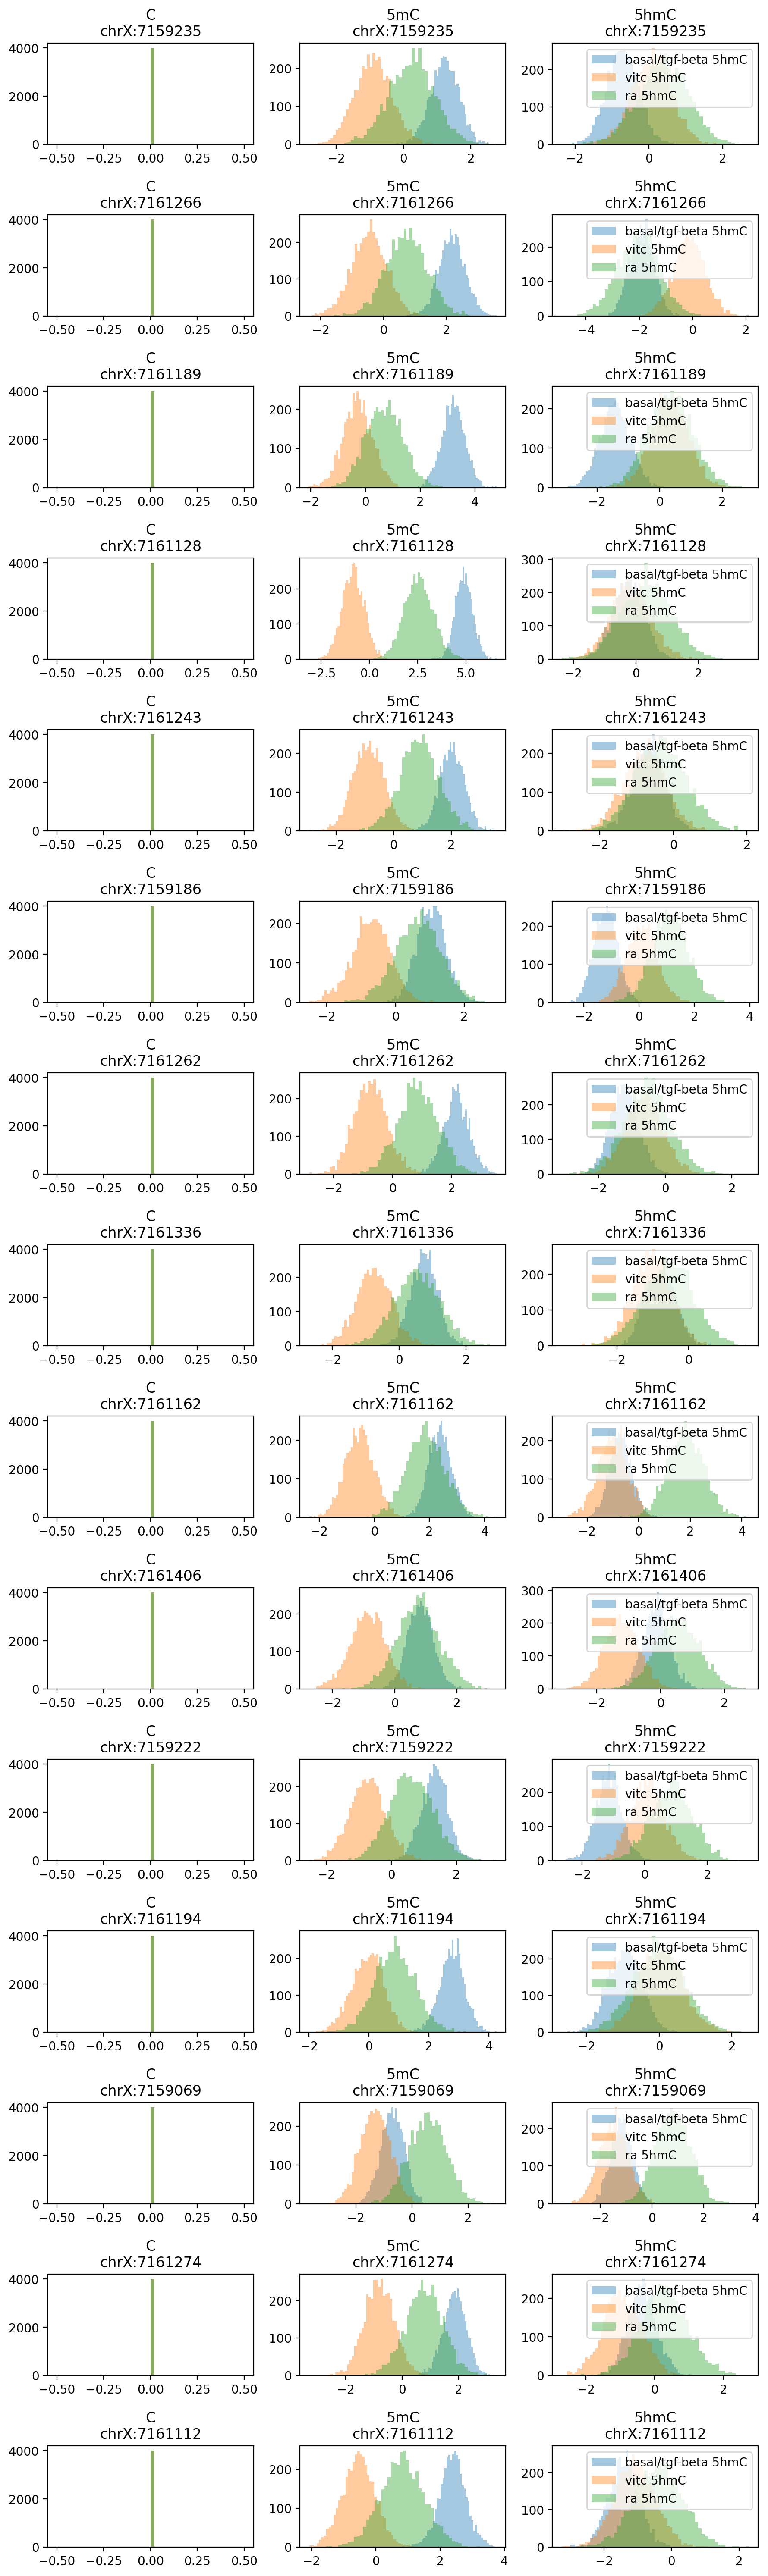

In [7]:
plot_coefficients(lux_result);